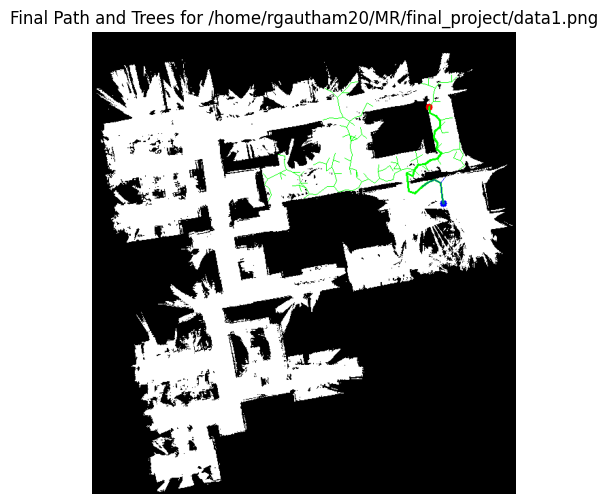

Results for /home/rgautham20/MR/final_project/data1.png:
  Iterations: 1632
  Path Length: 267.16
  Time Taken: 1.01 seconds
  Smoothness: 19.13 radians



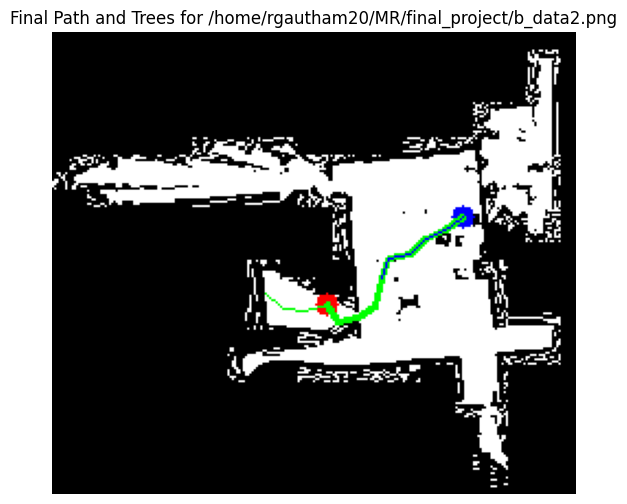

Results for /home/rgautham20/MR/final_project/b_data2.png:
  Iterations: 17
  Path Length: 90.86
  Time Taken: 0.00 seconds
  Smoothness: 4.68 radians



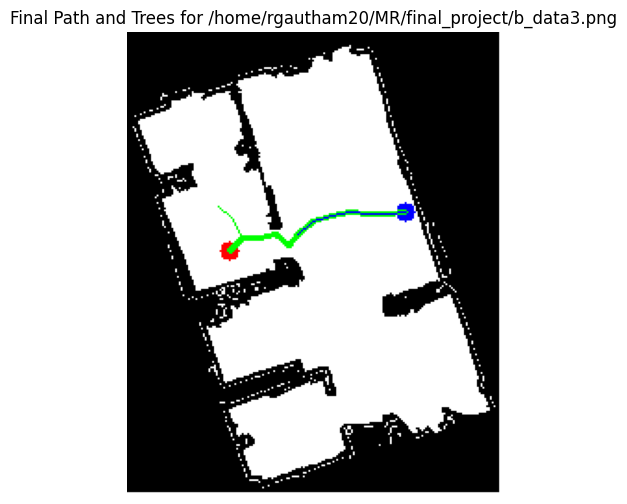

Results for /home/rgautham20/MR/final_project/b_data3.png:
  Iterations: 9
  Path Length: 106.52
  Time Taken: 0.00 seconds
  Smoothness: 4.69 radians



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import imageio
from collections import deque

class Node:
    def __init__(self, x, y, parent=None):
        self.x = x
        self.y = y
        self.parent = parent

def distance(p1, p2):
    return np.linalg.norm(np.array([p1.x, p1.y]) - np.array([p2.x, p2.y]))

def steer(from_node, to_node, step_size=10):
    theta = np.arctan2(to_node.y - from_node.y, to_node.x - from_node.x)
    new_x = int(from_node.x + step_size * np.cos(theta))
    new_y = int(from_node.y + step_size * np.sin(theta))
    return Node(new_x, new_y, from_node)

def is_collision_free(image, from_node, to_node):
    line = zip(
        np.linspace(from_node.x, to_node.x, num=20).astype(int),
        np.linspace(from_node.y, to_node.y, num=20).astype(int)
    )
    for (x, y) in line:
        if image[y, x] == 0:  # Obstacle in path (black pixel)
            return False
    return True

def get_random_node(image, goal, goal_bias=0.1):
    if np.random.rand() < goal_bias:
        return goal
    else:
        x = np.random.randint(0, image.shape[1])
        y = np.random.randint(0, image.shape[0])
        return Node(x, y)

def get_nearest_node(nodes, random_node):
    return min(nodes, key=lambda node: distance(node, random_node))

def backtrack_path(goal_node):
    path = deque()
    current_node = goal_node
    while current_node is not None:
        path.appendleft((current_node.x, current_node.y))
        current_node = current_node.parent
    return list(path)

def brrt(image, start, goal, max_iterations=2500, step_size=10, goal_tolerance=15):
    start_time = time.time()
    nodes_start = [start]
    nodes_goal = [goal]
    iterations = 0
    path_found = False
    images_for_gif = []

    while iterations < max_iterations:
        iterations += 1

        random_node = get_random_node(image, goal)
        nearest_start = get_nearest_node(nodes_start, random_node)
        new_start_node = steer(nearest_start, random_node, step_size)

        if is_collision_free(image, nearest_start, new_start_node):
            nodes_start.append(new_start_node)

            nearest_goal = get_nearest_node(nodes_goal, new_start_node)
            new_goal_node = steer(nearest_goal, new_start_node, step_size)

            if is_collision_free(image, nearest_goal, new_goal_node):
                nodes_goal.append(new_goal_node)

                if distance(new_start_node, new_goal_node) < goal_tolerance:
                    path_found = True
                    break

        # Visualization
        image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        for node in nodes_start:
            if node.parent:
                cv2.line(image_copy, (node.x, node.y), (node.parent.x, node.parent.y), (0, 255, 0), 1)
        for node in nodes_goal:
            if node.parent:
                cv2.line(image_copy, (node.x, node.y), (node.parent.x, node.parent.y), (255, 0, 0), 1)
        images_for_gif.append(image_copy)

    if path_found:
        path1 = backtrack_path(new_start_node)
        path2 = backtrack_path(new_goal_node)
        path = path1 + path2[::-1]
    else:
        path = []

    end_time = time.time()
    return path, nodes_start, nodes_goal, iterations, end_time - start_time, images_for_gif

def path_length(path):
    return sum(np.linalg.norm(np.array(path[i]) - np.array(path[i - 1])) for i in range(1, len(path)))

def smoothness(path):
    total_angle_change = 0
    for i in range(1, len(path) - 1):
        v1 = np.array(path[i]) - np.array(path[i - 1])
        v2 = np.array(path[i + 1]) - np.array(path[i])
        angle = np.arccos(np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0))
        total_angle_change += angle
    return total_angle_change

def process_image(image_path, start_coords, goal_coords, output_gif):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Convert start and goal coordinates to Node objects
    start_node = Node(start_coords[0], start_coords[1])
    goal_node = Node(goal_coords[0], goal_coords[1])

    # Run BRRT algorithm
    path, nodes_start, nodes_goal, iterations, time_taken, images_for_gif = brrt(img, start_node, goal_node)

    # Function to mark start and goal nodes on an image
    def mark_start_goal(image):
        cv2.circle(image, start_coords, 5, (0, 0, 255), -1)  # Start node (red)
        cv2.circle(image, goal_coords, 5, (255, 0, 0), -1)   # Goal node (blue)

    # Create visualization frames
    images_with_start_goal = []
    for img_frame in images_for_gif:
        img_copy = img_frame.copy()
        mark_start_goal(img_copy)
        images_with_start_goal.append(img_copy)

    if path:
        # Draw the final path on the last frame
        final_frame = img_color.copy()
        mark_start_goal(final_frame)
        for i in range(1, len(path)):
            cv2.line(final_frame, path[i - 1], path[i], (0, 255, 0), 2)

        # Ensure the trees (nodes) are visible after path is drawn
        for node in nodes_start:
            if node.parent:
                cv2.line(final_frame, (node.x, node.y), (node.parent.x, node.parent.y), (0, 255, 0), 1)
        for node in nodes_goal:
            if node.parent:
                cv2.line(final_frame, (node.x, node.y), (node.parent.x, node.parent.y), (255, 0, 0), 1)

        # Add the final frame to the list of images for GIF
        images_with_start_goal.append(final_frame)

        # Save the GIF
        imageio.mimsave(output_gif, images_with_start_goal, duration=0.02)

        # Convert final_frame to RGB for displaying with plt
        final_frame_rgb = cv2.cvtColor(final_frame, cv2.COLOR_BGR2RGB)

        # Display the final frame with matplotlib
        plt.figure(figsize=(10, 6))
        plt.imshow(final_frame_rgb)
        plt.title(f"Final Path and Trees for {image_path}")
        plt.axis("off")
        plt.show()

        print(f"Results for {image_path}:")
        print(f"  Iterations: {iterations}")
        print(f"  Path Length: {path_length(path):.2f}")
        print(f"  Time Taken: {time_taken:.2f} seconds")
        print(f"  Smoothness: {smoothness(path):.2f} radians\n")
    else:
        print(f"Path not found for {image_path}.")

# Inputs with image paths and start/goal coordinates
inputs = [
    {"image_path": "/home/rgautham20/MR/final_project/data1.png", "start": (495, 110), "goal": (516, 252), "output_gif": "/home/rgautham20/MR/final_project/brrt_expansion_1.gif"},
    {"image_path": "/home/rgautham20/MR/final_project/b_data2.png", "start": (125, 124), "goal": (187, 84), "output_gif": "/home/rgautham20/MR/final_project/brrt_expansion_2.gif"},
    {"image_path": "/home/rgautham20/MR/final_project/b_data3.png", "start": (55, 118), "goal": (150, 97), "output_gif": "/home/rgautham20/MR/final_project/brrt_expansion_3.gif"}
]
for input_data in inputs:
    process_image(input_data["image_path"], input_data["start"], input_data["goal"], input_data["output_gif"])
